이번 강의에서는 교재 Example 8.1: Dyna Maze를 구현합니다. 
  - 성신여자대학교 AI융합학부 강화학습 수업을 위해 작성한 자료입니다. 2025년 8월 26일 초안을 작성하였고, 2025년 10월 15일 업데이트하였습니다. 
  - 코드는 2018년 작성한 코드를 바탕으로 Claude Pro를 이용해 변수명과 그림 그리는 방법을 수정하였습니다. 

# 1. Example 8.1: Dyna Maze
## 1.1. Problem Definition
주어진 문제를 구현합니다. 주석을 달아 두었으니 쉽게 이해할 수 있을 거예요.

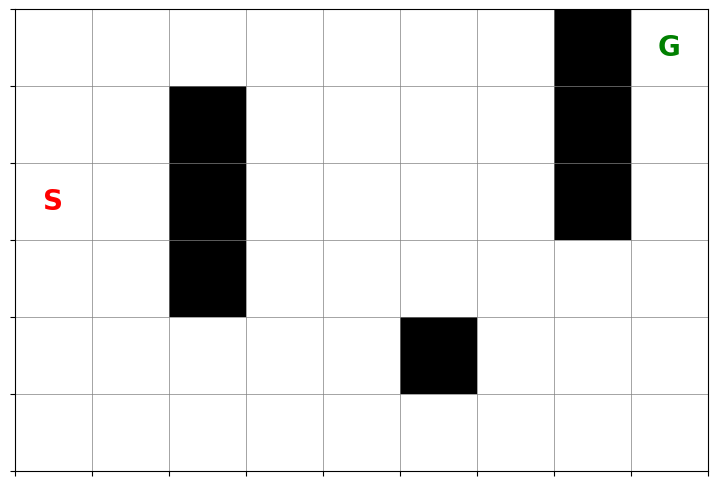

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random 

n_rows, n_cols = 6, 9
start_state = (2, 0) # (row, col)
goal_state = (0, 8)  # (row, col)

# 벽 위치 정의를 정의하고,
walls = [
    (1, 2), (2, 2), (3, 2),
    (4, 5), (0, 7), (1, 7), (2, 7)
]

# 행동을 정의해 줍니다. 사방으로 움직일 수 있습니다(Up, Down, Left, Right).
ACTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]
n_actions = len(ACTIONS) # 지난 코드로부터 눈치 챈 학생들도 있겠지만, 중간고사 이전 알고리즘은 모두 tabular RL이므로 action의 숫자가 정해져 있습니다. 

def is_valid_state(r, c):
    """주어진 (r, c)가 미로 범위 내에 있고 벽이 아닌지 확인하는 함수입니다. 코딩테스트를 준비해 보았다면 익숙하죠?"""
    return 0 <= r < n_rows and 0 <= c < n_cols and (r, c) not in walls

def step_dyna_maze(state, action_idx):
    """
    Dyna Maze 환경에서 한 스텝 진행하는 함수입니다. 지난 코드들을 이해하였다면 어렵지 않게 작성할 수 있을 것입니다.
    :param state: 현재 상태 (r, c)
    :param action_idx: 선택된 행동의 인덱스 (0:상, 1:하, 2:좌, 3:우)
    :return: 다음 상태, 보상, 종료 여부
    """
    r, c = state
    dr, dc = ACTIONS[action_idx]
    
    # 다음 상태 후보를 가져오고,
    next_r, next_c = r + dr, c + dc
    potential_next_state = (next_r, next_c)

    reward = 0 # 문제에 따라 기본 보상은 0입니다.

    if not is_valid_state(next_r, next_c):
        next_state = state # 미로 밖으로 나가거나 벽으로 이동하려는 경우, 상태는 그대로 유지
    else:
        next_state = potential_next_state

    done = (next_state == goal_state)
    if done:
        reward = 1 # 목표점에 도달하면 +1 보상
    
    return next_state, reward, done

def draw_dyna_maze():
    """Dyna-Maze 환경을 시각화하는 함수입니다. Claude Pro의 도움을 받아 작성하였습니다."""
    fig, ax = plt.subplots(figsize=(n_cols, n_rows))
    maze = np.zeros((n_rows, n_cols)) 
    
    for r, c in walls:
        maze[r, c] = 1 # 1은 벽입니다.
        
    ax.imshow(maze, cmap='binary', origin='upper') 
    
    ax.set_xticks(np.arange(-0.5, n_cols, 1))
    ax.set_yticks(np.arange(-0.5, n_rows, 1))
    ax.grid(True, color='gray', linewidth=0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.text(start_state[1], start_state[0], 'S', 
            ha='center', va='center', color='red', fontsize=20, fontweight='bold')
    ax.text(goal_state[1], goal_state[0], 'G', 
            ha='center', va='center', color='green', fontsize=20, fontweight='bold')
            
    plt.show()

draw_dyna_maze()

def plot_policy(Q_table, title="Optimal Policy"):
    """학습을 마친 후 Q-테이블로부터 정책을 시각화하는 함수입니다."""
    fig, ax = plt.subplots(figsize=(n_cols, n_rows))
    maze_grid = np.zeros((n_rows, n_cols))
    
    for r, c in walls:
        maze_grid[r, c] = -1 
        
    ax.imshow(maze_grid, cmap='Pastel1', origin='upper') 
    
    ax.set_xticks(np.arange(-0.5, n_cols, 1))
    ax.set_yticks(np.arange(-0.5, n_rows, 1))
    ax.grid(True, color='gray', linewidth=0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax.text(start_state[1], start_state[0], 'S', ha='center', va='center', color='red', fontsize=20)
    ax.text(goal_state[1], goal_state[0], 'G', ha='center', va='center', color='green', fontsize=20)

    for r in range(n_rows):
        for c in range(n_cols):
            if (r, c) in walls or (r, c) == goal_state:
                continue
            
            best_action_idx = np.argmax(Q_table[r, c])
            dr, dc = ACTIONS[best_action_idx]
            
            ax.arrow(c, r, dc * 0.4, dr * 0.4, 
                     head_width=0.2, head_length=0.2, fc='blue', ec='blue', length_includes_head=True)
            
    ax.set_title(title, fontsize=16)
    plt.show()

def eps_greedy(Q_table, state, eps):
    """ε-greedy 함수를 구현하였고, 지난 코드와 거의 동일합니다. Q-learning과 Dyna 모두 ε-greedy 정책을 사용합니다."""
    if np.random.rand() < eps:
        return np.random.randint(n_actions)
    
    r, c = state
    q_values_for_state = Q_table[r, c]
    
    max_q = np.max(q_values_for_state)
    best_actions = np.argwhere(q_values_for_state == max_q).flatten()
    
    return np.random.choice(best_actions)

## 1.2. Q-learning, for estimating $Q \approx q_\ast$ (Chapter 7)

기존에 배웠던 Q-learning을 먼저 구현해 봅시다. 이미 구현했던 알고리즘이니 문제에 맞게 수정해 주면 됩니다. Figure 8.2에서 "direct RL"에 해당하겠지요?

Episode    1: Steps = 1143
Episode   10: Steps = 34
Episode   20: Steps = 140
Episode   30: Steps = 42
Episode   40: Steps = 17
Episode   50: Steps = 16


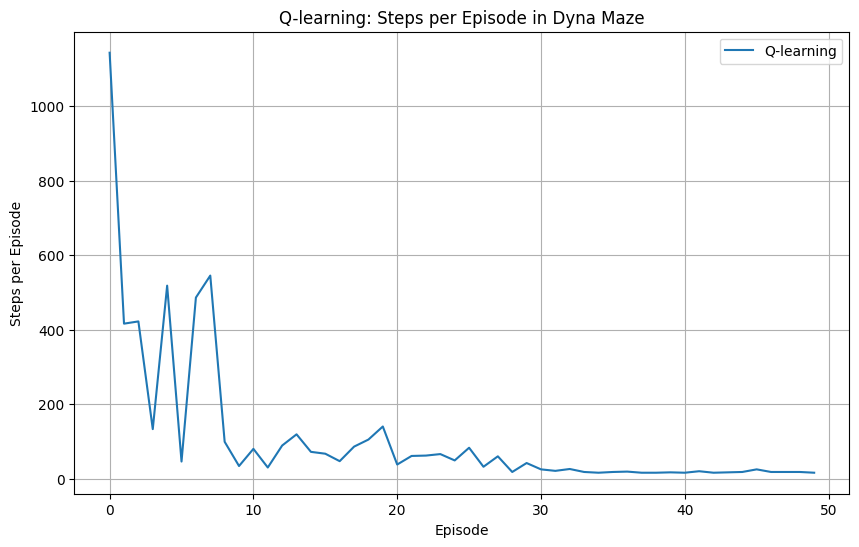

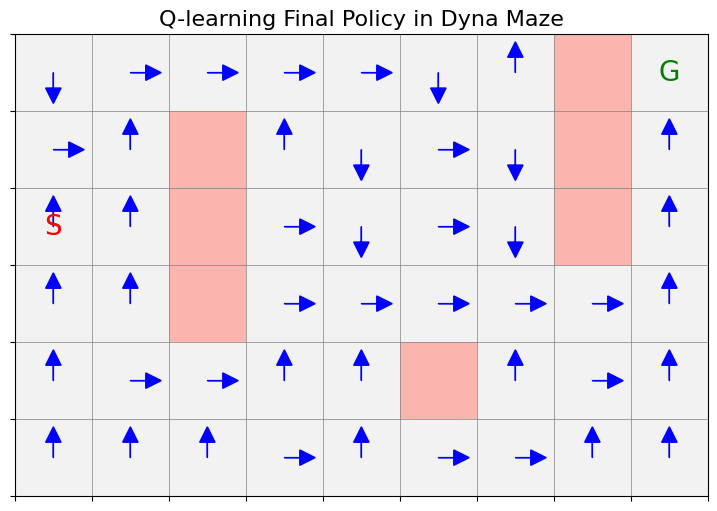

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 교재에 주어진 파라미터를 설정해 봅시다.
gamma = 0.95
alpha = 0.1     # 학습률
epsilon = 0.1   # ε-greedy 탐험 확률
episodes = 50   # 에피소드 수 

# Q 테이블을 초기화합니다. 우리는 지금 fintite problem 을 풀고 있어요. 따라서 Q를 테이블로 만들 수 있습니다. 
Q_q_learning = np.zeros((n_rows, n_cols, n_actions))
ep_steps_q_learning = [] # Figure 8.2를 보면 각 에피소드당 스텝 수를 이용해 알고리즘을 비교했지요?

for ep in range(1, episodes + 1):
    s = start_state
    steps_count = 0 # 그래프에 알고리즘을 비교하기 위해 사용할 에피소드당 스텝 수이므로, 매번 초기화 시켜 줍니다.
    done = False

    while not done:
        a_idx = eps_greedy(Q_q_learning, s, epsilon)
        ns, r, done = step_dyna_maze(s, a_idx) 
        steps_count += 1 # 스텝 수를 증가시켜서 나중에 그래프로 그려줍니다.

        td_target = r + gamma * np.max(Q_q_learning[ns[0], ns[1]]) if not done else r
        td_error  = td_target - Q_q_learning[s[0], s[1], a_idx]
        Q_q_learning[s[0], s[1], a_idx] += alpha * td_error

        s = ns
    
    ep_steps_q_learning.append(steps_count) # 에피소드당 스텝 수를 기록합니다.
    if ep % 10 == 0 or ep == 1:
        print(f"Episode {ep:4d}: Steps = {steps_count}")

plt.figure(figsize=(10, 6))
plt.plot(ep_steps_q_learning, label='Q-learning')
plt.xlabel("Episode")
plt.ylabel("Steps per Episode")
plt.title("Q-learning: Steps per Episode in Dyna Maze")
plt.grid(True)
plt.legend()
plt.show()

plot_policy(Q_q_learning, "Q-learning Final Policy in Dyna Maze")

## 1.3. Tabular Dyna-Q
Planning을 반영한 알고리즘으로 업데이트 해 봅시다. 

Episode    1: Steps = 820
Episode   10: Steps = 17
Episode   20: Steps = 16
Episode   30: Steps = 18
Episode   40: Steps = 14
Episode   50: Steps = 16


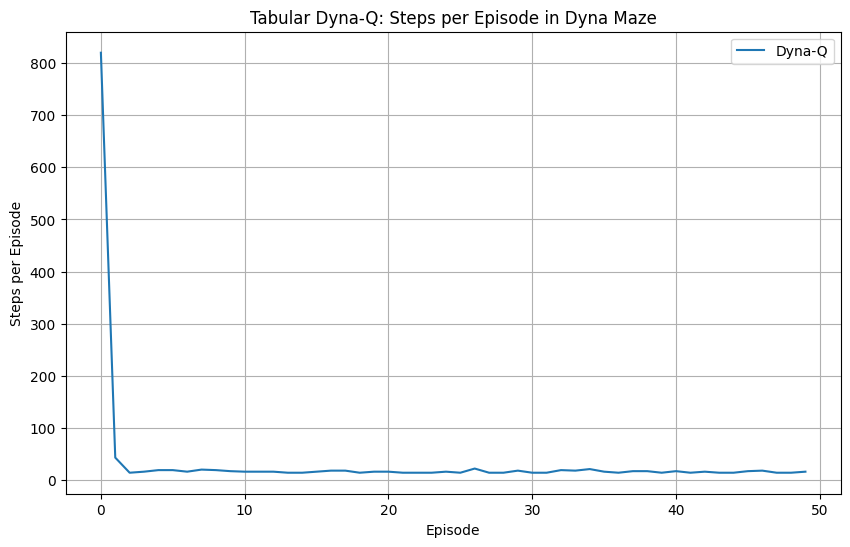

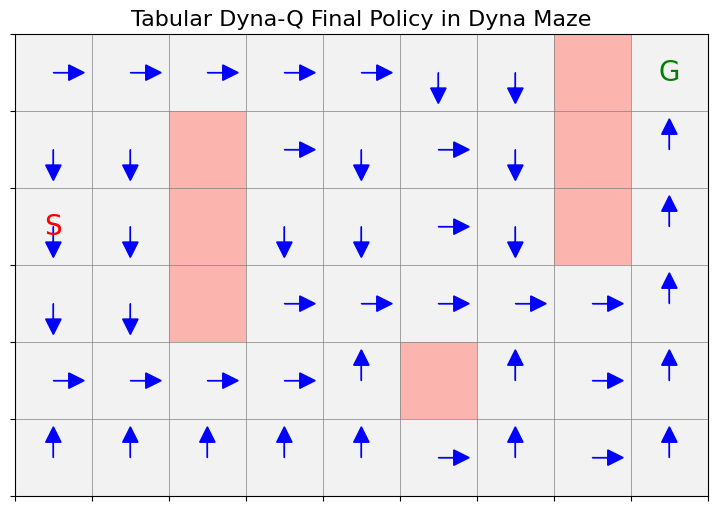

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import random 

gamma = 0.95
alpha = 0.1
epsilon = 0.1
episodes = 50
n_planning_steps = 50 # 계획(planning) 스텝 수입니다. 교재는 50을 사용했습니다(k=50).

Q_dyna_q = np.zeros((n_rows, n_cols, n_actions))

# Planning을 사용하면 크게 달라지는 부분이 바로 모델 딕셔너리가 추가된다는 점입니다. 
model = {} 

# 나머지는 Q-learning과 거의 동일하니, 동일한 부분은 주석을 생략합니다.
ep_steps_dyna_q = []

for ep in range(1, episodes + 1):
    s = start_state
    steps_count = 0 
    done = False

    while not done:
        a_idx = eps_greedy(Q_dyna_q, s, epsilon)
        
        ns, r, done = step_dyna_maze(s, a_idx) 
        steps_count += 1

        td_target = r + gamma * np.max(Q_dyna_q[ns[0], ns[1]]) if not done else r
        td_error  = td_target - Q_dyna_q[s[0], s[1], a_idx]
        Q_dyna_q[s[0], s[1], a_idx] += alpha * td_error

        model[(s, a_idx)] = (ns, r)

        for _ in range(n_planning_steps):
            if not model: 
                break
            
            experienced_s_a_pairs = list(model.keys())
            rand_s, rand_a_idx = random.choice(experienced_s_a_pairs)
            
            pred_ns, pred_r = model[(rand_s, rand_a_idx)]

            pred_td_target = pred_r + gamma * np.max(Q_dyna_q[pred_ns[0], pred_ns[1]]) if pred_ns != goal_state else pred_r
            pred_td_error = pred_td_target - Q_dyna_q[rand_s[0], rand_s[1], rand_a_idx]
            Q_dyna_q[rand_s[0], rand_s[1], rand_a_idx] += alpha * pred_td_error
            
        s = ns 

    ep_steps_dyna_q.append(steps_count)
    if ep % 10 == 0 or ep == 1:
        print(f"Episode {ep:4d}: Steps = {steps_count}")

plt.figure(figsize=(10, 6))
plt.plot(ep_steps_dyna_q, label='Dyna-Q')
plt.xlabel("Episode")
plt.ylabel("Steps per Episode")
plt.title("Tabular Dyna-Q: Steps per Episode in Dyna Maze")
plt.grid(True)
plt.legend()
plt.show()

# 최종 정책 시각화
plot_policy(Q_dyna_q, "Tabular Dyna-Q Final Policy in Dyna Maze")

## 1.4. Figure 8.2

Figure 8.2처럼 planning step 수(k)에 따른 학습 추이의 변화를 비교해 봅시다.


=== Dyna-Q (k=0) ===
Episode   1: Steps = 453
Episode  10: Steps = 38
Episode  20: Steps = 16
Episode  30: Steps = 14
Episode  40: Steps = 16
Episode  50: Steps = 18

=== Dyna-Q (k=1) ===
Episode   1: Steps = 353
Episode  10: Steps = 19
Episode  20: Steps = 16
Episode  30: Steps = 15
Episode  40: Steps = 16
Episode  50: Steps = 19

=== Dyna-Q (k=5) ===
Episode   1: Steps = 2431
Episode  10: Steps = 18
Episode  20: Steps = 18
Episode  30: Steps = 16
Episode  40: Steps = 16
Episode  50: Steps = 17

=== Dyna-Q (k=10) ===
Episode   1: Steps = 259
Episode  10: Steps = 16
Episode  20: Steps = 18
Episode  30: Steps = 19
Episode  40: Steps = 20
Episode  50: Steps = 19


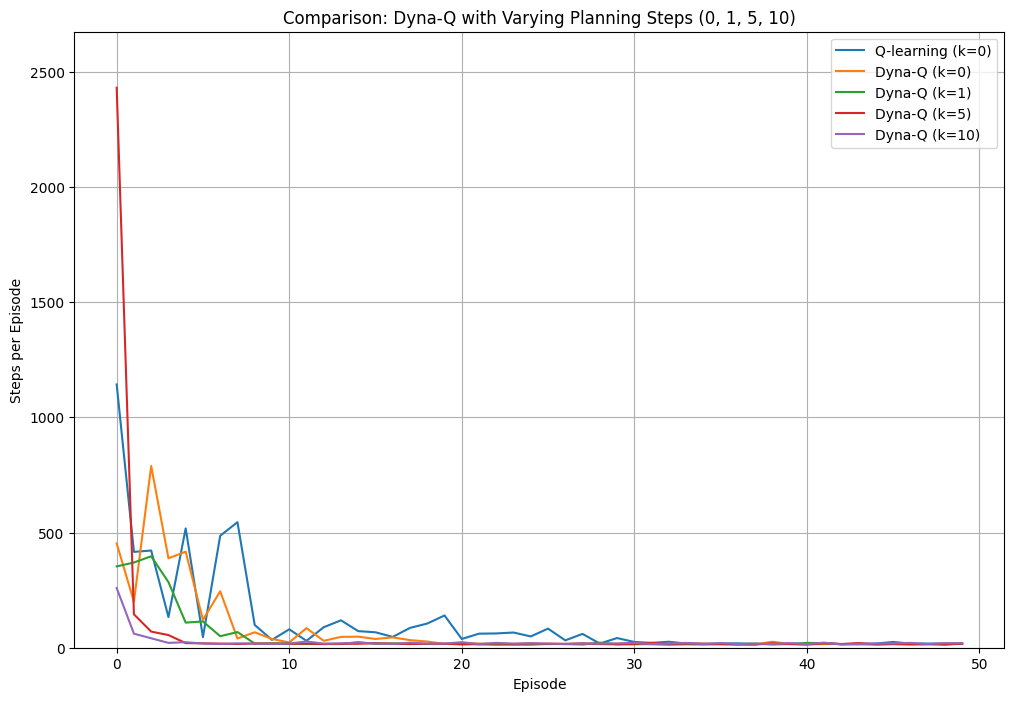

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import random

gamma = 0.95
alpha = 0.1
epsilon = 0.1
episodes = 50

# 비교하려는 planning step 값들입니다. 교재에서는 0, 5, 50을 비교했습니다. 
planning_steps_values = [0, 1, 5, 10]

# 결과 저장용 딕셔너리입니다.
all_steps_results = {}

# 기존 Q-learning (k=0) 결과가 있을 경우 불러오고, 없으면 새로 계산합니다. 위 셀들을 실행하지 않고 이 셀만 실행할 경우를 대비한 코드입니다.
if 'ep_steps_q_learning' not in locals():
    print("기존 Q-learning 결과 없음. 새로 계산합니다.")
    ep_steps_q_learning = []
    Q_q_learning = np.zeros((n_rows, n_cols, n_actions))
    for ep in range(episodes):
        s = start_state
        done = False
        steps_count = 0
        while not done:
            a_idx = eps_greedy(Q_q_learning, s, epsilon)
            ns, r, done = step_dyna_maze(s, a_idx)
            steps_count += 1

            td_target = r + gamma * np.max(Q_q_learning[ns[0], ns[1], :]) if not done else r
            td_error = td_target - Q_q_learning[s[0], s[1], a_idx]
            Q_q_learning[s[0], s[1], a_idx] += alpha * td_error
            s = ns
        ep_steps_q_learning.append(steps_count)
    all_steps_results['Q-learning (k=0)'] = ep_steps_q_learning
else:
    all_steps_results['Q-learning (k=0)'] = ep_steps_q_learning

for n_planning_steps in planning_steps_values:
    print(f"\n=== Dyna-Q (k={n_planning_steps}) ===")
    Q_dyna_q = np.zeros((n_rows, n_cols, n_actions))
    model = {}  # (s, a) → (s′, r)
    ep_steps_dyna_q = []

    for ep in range(1, episodes + 1):
        s = start_state
        done = False
        steps_count = 0

        while not done:
            a_idx = eps_greedy(Q_dyna_q, s, epsilon)
            ns, r, done = step_dyna_maze(s, a_idx)
            steps_count += 1

            # 실제 경험으로 Q 업데이트(1-step Q-learning)하며, 원래 알고 있던 Q-learning 과 같습니다.
            td_target = r + gamma * np.max(Q_dyna_q[ns[0], ns[1], :]) if not done else r
            td_error = td_target - Q_dyna_q[s[0], s[1], a_idx]
            Q_dyna_q[s[0], s[1], a_idx] += alpha * td_error

            # 모델 갱신하고,
            model[(s, a_idx)] = (ns, r)

            # Planning하는 단계입니다. 여기가 다르죠?
            for _ in range(n_planning_steps):
                if not model:
                    break
                rand_s, rand_a = random.choice(list(model.keys()))
                pred_ns, pred_r = model[(rand_s, rand_a)]

                pred_td_target = pred_r + gamma * np.max(Q_dyna_q[pred_ns[0], pred_ns[1], :]) if pred_ns != goal_state else pred_r
                pred_td_error = pred_td_target - Q_dyna_q[rand_s[0], rand_s[1], rand_a]
                Q_dyna_q[rand_s[0], rand_s[1], rand_a] += alpha * pred_td_error

            s = ns

        ep_steps_dyna_q.append(steps_count)
        if ep % 10 == 0 or ep == 1:
            print(f"Episode {ep:3d}: Steps = {steps_count}")

    all_steps_results[f'Dyna-Q (k={n_planning_steps})'] = ep_steps_dyna_q

plt.figure(figsize=(12, 8))
for label, steps_data in all_steps_results.items():
    plt.plot(steps_data, label=label)
plt.xlabel("Episode")
plt.ylabel("Steps per Episode")
plt.title("Comparison: Dyna-Q with Varying Planning Steps (0, 1, 5, 10)")
plt.grid(True)
plt.legend()
plt.ylim(0, max(max(steps) for steps in all_steps_results.values()) * 1.1)
plt.show()

## 1.5. Dyna-Q vs. n-step Q
그렇다면 이제 의문이 듭니다. 계산을 어차피 똑같이 하는데 굳이 planning을 할 필요가 있을까요? Planning step만큼 7장에서 배운 n-step Q-learning 알고리즘을 쓰면 똑같지 않나요?

아래 코드를 비교해 봅시다. 주석은 일부러 제거하였으니, 스스로 읽어나가 보세요. 

Episode    1: 10-step Q-learning steps = 274, Dyna-Q (k=10) steps = 469
Episode   10: 10-step Q-learning steps =  39, Dyna-Q (k=10) steps =  16
Episode   20: 10-step Q-learning steps =  28, Dyna-Q (k=10) steps =  14
Episode   30: 10-step Q-learning steps =  22, Dyna-Q (k=10) steps =  14
Episode   40: 10-step Q-learning steps =  23, Dyna-Q (k=10) steps =  15
Episode   50: 10-step Q-learning steps =  16, Dyna-Q (k=10) steps =  14


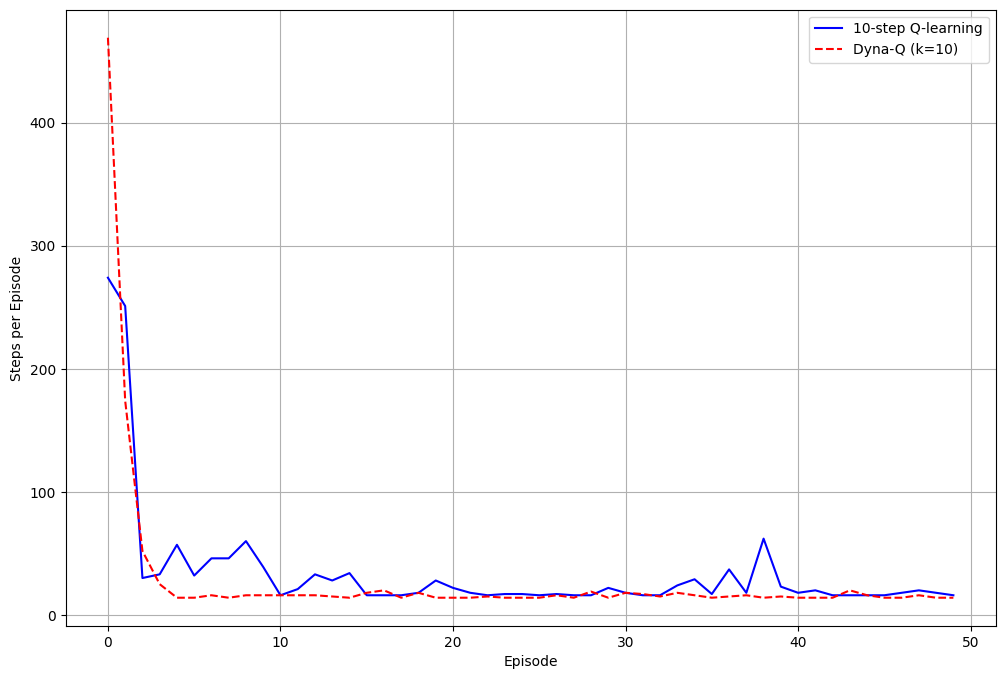

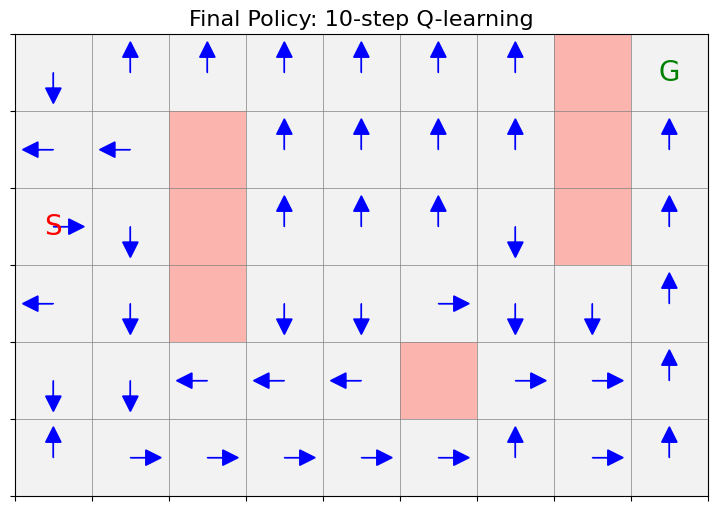

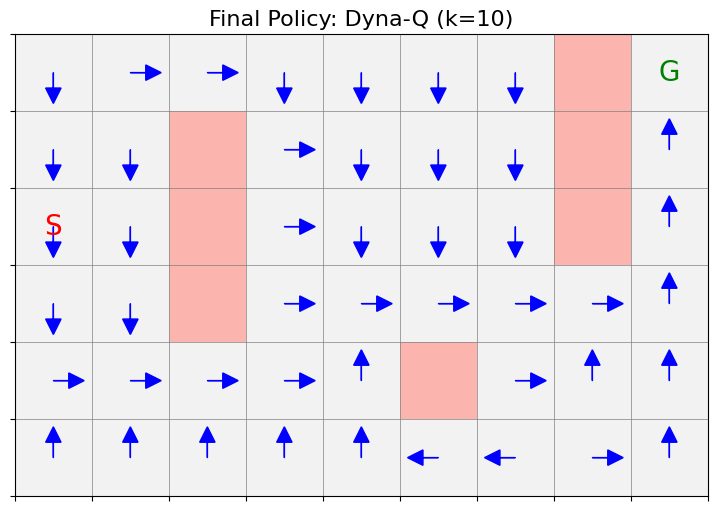

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import random
import collections

gamma = 0.95
alpha = 0.1
epsilon = 0.1
episodes = 50
n_step = 10
n_planning_steps = 10

Q_10_step_q_learning = np.zeros((n_rows, n_cols, n_actions))
Q_dyna_q_k10 = np.zeros((n_rows, n_cols, n_actions))

model_k10 = {}

ep_steps_10_step_q_learning = []
ep_steps_dyna_q_k10 = []

for ep in range(1, episodes + 1):
    s = start_state
    a = eps_greedy(Q_10_step_q_learning, s, epsilon)
    T = float('inf')
    t = 0
    tau = 0
    episode_done = False

    states = [s]
    actions = [a]
    rewards = [0.0]
    steps_count = 0

    while True:
        if t < T:
            ns, r, done = step_dyna_maze(s, a)
            steps_count += 1
            rewards.append(r)
            states.append(ns)
            if done:
                T = t + 1
            else:
                next_a = eps_greedy(Q_10_step_q_learning, ns, epsilon)
                actions.append(next_a)
            
            s, a = ns, next_a if not done else None

        tau = t - n_step + 1
        if tau >= 0:
            n = min(n_step, T - tau)
            G = 0.0
            for i in range(1, n + 1):
                G += (gamma ** (i - 1)) * rewards[tau + i]
            if tau + n < T:
                G += (gamma ** n) * np.max(Q_10_step_q_learning[states[tau + n][0], states[tau + n][1], :])

            s_tau = states[tau]
            a_tau = actions[tau]
            Q_10_step_q_learning[s_tau[0], s_tau[1], a_tau] += alpha * (G - Q_10_step_q_learning[s_tau[0], s_tau[1], a_tau])

        t += 1
        if tau == T - 1:
            break

    ep_steps_10_step_q_learning.append(steps_count)

    s_dyna = start_state
    done_dyna = False
    steps_dyna = 0

    while not done_dyna:
        a_dyna = eps_greedy(Q_dyna_q_k10, s_dyna, epsilon)
        ns_dyna, r_dyna, done_dyna = step_dyna_maze(s_dyna, a_dyna)
        steps_dyna += 1

        td_target = r_dyna + gamma * np.max(Q_dyna_q_k10[ns_dyna[0], ns_dyna[1], :]) if not done_dyna else r_dyna
        td_error = td_target - Q_dyna_q_k10[s_dyna[0], s_dyna[1], a_dyna]
        Q_dyna_q_k10[s_dyna[0], s_dyna[1], a_dyna] += alpha * td_error

        model_k10[(s_dyna, a_dyna)] = (ns_dyna, r_dyna)

        for _ in range(n_planning_steps):
            if not model_k10:
                break
            rand_s, rand_a = random.choice(list(model_k10.keys()))
            pred_ns, pred_r = model_k10[(rand_s, rand_a)]
            pred_target = pred_r + gamma * np.max(Q_dyna_q_k10[pred_ns[0], pred_ns[1], :]) if pred_ns != goal_state else pred_r
            pred_error = pred_target - Q_dyna_q_k10[rand_s[0], rand_s[1], rand_a]
            Q_dyna_q_k10[rand_s[0], rand_s[1], rand_a] += alpha * pred_error

        s_dyna = ns_dyna

    ep_steps_dyna_q_k10.append(steps_dyna)

    if ep % 10 == 0 or ep == 1:
        print(f"Episode {ep:4d}: 10-step Q-learning steps = {steps_count:3d}, Dyna-Q (k={n_planning_steps}) steps = {steps_dyna:3d}")

plt.figure(figsize=(12, 8))
plt.plot(ep_steps_10_step_q_learning, label=f'{n_step}-step Q-learning', color='blue')
plt.plot(ep_steps_dyna_q_k10, label=f'Dyna-Q (k={n_planning_steps})', color='red', linestyle='--')
plt.xlabel("Episode")
plt.ylabel("Steps per Episode")
plt.legend()
plt.grid(True)
plt.show()

plot_policy(Q_10_step_q_learning, f"Final Policy: {n_step}-step Q-learning")
plot_policy(Q_dyna_q_k10, f"Final Policy: Dyna-Q (k={n_planning_steps})")